In [8]:
from google.colab import drive
drive.mount('/content/drive')

import os, cv2, csv, json, numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

from skimage.filters import frangi, sato, meijering
from skimage.morphology import (skeletonize, remove_small_objects,
                                binary_closing, binary_dilation, disk,
                                medial_axis)
from scipy.ndimage import distance_transform_edt

image_dir = "/content/drive/MyDrive/dataset3/images3"
mask_dir  = "/content/drive/MyDrive/dataset3/masks2"
ridge_dir = "/content/drive/MyDrive/dataset3/masks_ridge"
results_dir = "/content/drive/MyDrive/dataset3/results_ridge_filled"

os.makedirs(mask_dir, exist_ok=True)
os.makedirs(ridge_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

CSV_PER_IMAGE  = os.path.join(results_dir, "metrics_per_image.csv")
CSV_AGGREGATE  = os.path.join(results_dir, "metrics_aggregate.csv")
SUMMARY_JSON   = os.path.join(results_dir, "summary.json")


S_LOW       = 100
V_LOW       = 80
R_DOM_RELAX = 35
R_DOM_STRICT= 45
OTSU_SCALE  = 1.05
KSIZE_OPEN  = 5
OPEN_ITERS  = 1
KSIZE_CLOSE = 7
CLOSE_ITERS = 2
MIN_AREA_ABS  = 400
MIN_AREA_FRAC = 0.001
WHITE_CUTOFF  = 240
EXCLUDE_LOWER_FACE = False
LOWER_FACE_FRAC    = 0.30


def load_bgr_png(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read: {path}")
    if img.ndim == 3 and img.shape[2] == 4:
        img = img[:, :, :3]
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img

def imread_gray(path):
    g = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if g is None:
        raise ValueError(f"Cannot read: {path}")
    return g

def to_bool_mask(img_gray, threshold=0):
    return (img_gray > threshold)

def ensure_same_size(pred_bool, target_shape_hw):
    if pred_bool.shape == target_shape_hw:
        return pred_bool
    pred_u8 = pred_bool.astype(np.uint8)*255
    resized = cv2.resize(pred_u8, (target_shape_hw[1], target_shape_hw[0]), interpolation=cv2.INTER_NEAREST)
    return resized > 0


def build_mask(bgr):
    H, W = bgr.shape[:2]
    b, g, r = cv2.split(bgr)

    near_white = (r > 240) & (g > 240) & (b > 240)

    denom = (r.astype(np.float32) + g.astype(np.float32) + b.astype(np.float32) + 1e-6)
    redness = r.astype(np.float32) / denom

    red8 = np.uint8(np.clip(redness*255, 0, 255))
    thr, _ = cv2.threshold(red8, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    thr_scaled = int(thr * 0.95)  # loosen a bit
    mask = (red8 >= thr_scaled).astype(np.uint8) * 255

    mask[near_white] = 0

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (KSIZE_OPEN, KSIZE_OPEN))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k, iterations=OPEN_ITERS)
    k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (KSIZE_CLOSE, KSIZE_CLOSE))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k2, iterations=CLOSE_ITERS)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask[:] = 0
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    min_area = max(MIN_AREA_ABS, int(MIN_AREA_FRAC * H * W))
    keep = np.zeros(num, dtype=bool)
    for i in range(1, num):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            keep[i] = True
    out = np.zeros_like(mask)
    out[np.isin(labels, np.where(keep)[0])] = 255
    return out  # lesion = white


def ridge_lines_from_gt(
    bgr, gt_mask,
    sigmas=(1,2,3,4,5,6),
    exclude_edge_band_px=8,
    min_cov=0.002, max_cov=0.012,
    min_branch_px=60, prune_iters=5,
    line_thickness=3,
    include_ring=True, ring_thickness=3,
    fill_inside=True,
    erode_inside_px=0
):
    def _clahe_L(bgr):
        lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
        L   = lab[...,0]
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        return clahe.apply(L)

    def _gabor_bank(L8, angles=(0,30,60,90,120,150), ksize=17, sigma=4.0, lambd=8.0, gamma=0.5):
        f = L8.astype(np.float32)/255.0
        best = np.zeros_like(f, np.float32)
        for th in angles:
            k = cv2.getGaborKernel((ksize, ksize), sigma, np.deg2rad(th), lambd, gamma, 0, ktype=cv2.CV_32F)
            resp = cv2.filter2D(f, cv2.CV_32F, k)
            best = np.maximum(best, resp)
        best -= best.min(); best /= (best.max()+1e-8)
        return best

    def _find_endpoints(skel_bool):
        K = np.array([[1,1,1],[1,0,1],[1,1,1]], np.uint8)
        nb = cv2.filter2D(skel_bool.astype(np.uint8), -1, K, borderType=cv2.BORDER_CONSTANT)
        return skel_bool & (nb == 1)

    def _ring_from_gt(gt_mask, thickness=3):
        gt = (gt_mask>0).astype(np.uint8)*255
        cnts,_ = cv2.findContours(gt, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
        out = np.zeros_like(gt)
        if cnts:
            cv2.drawContours(out, cnts, -1, 255, thickness=thickness)
        return out>0

    roi = (gt_mask>0)
    if roi.sum()==0:
        return np.zeros_like(gt_mask, np.uint8)


    din  = distance_transform_edt(roi)
    dout = distance_transform_edt(~roi)
    edge_band = (din<=exclude_edge_band_px) | (dout<=exclude_edge_band_px)


    L8    = _clahe_L(bgr)
    Lnorm = L8.astype(np.float32)/255.0
    Vg = _gabor_bank(L8)
    F  = frangi(Lnorm,   sigmas=sigmas, black_ridges=False)
    S1 = sato(Lnorm,     sigmas=sigmas, black_ridges=False)
    S2 = sato(1.0-Lnorm, sigmas=sigmas, black_ridges=True)
    M  = meijering(Lnorm, sigmas=sigmas, black_ridges=False)

    cues = []
    for m in (Vg,F,S1,S2,M):
        m = m.astype(np.float32); m-=m.min(); m/= (m.max()+1e-8); cues.append(m)
    V = np.maximum.reduce(cues)
    V *= roi.astype(np.float32)
    V[edge_band] = 0.0


    sk = None
    for pct in (99,98,97,96,95,94,93,92,90,88,86,84,82,80,78,76,74,72,70):
        thr = np.percentile(V[roi], pct)
        bw  = (V>=thr) & roi
        bw  = binary_closing(bw, disk(1))
        s   = skeletonize(bw)
        s   = remove_small_objects(s, min_size=min_branch_px)
        cov = s.sum()/roi.sum()
        if min_cov <= cov <= max_cov:
            sk = s; break

    if sk is None or sk.sum()<min_cov*roi.sum():
        sk,_ = medial_axis(roi, return_distance=True)
        sk &= ~edge_band
        sk  = remove_small_objects(sk, min_size=min_branch_px//2)

    for _ in range(prune_iters):
        ep = _find_endpoints(sk)
        sk = sk & ~ep

    ridges = binary_dilation(sk, disk(max(1, line_thickness//2)))

    if include_ring:
        ridges |= _ring_from_gt(gt_mask, thickness=ring_thickness)

    ridges = (ridges.astype(np.uint8)*255)  # white lines on black


    if fill_inside:
        inside = (gt_mask>0).astype(np.uint8)*255
        if erode_inside_px>0:
            k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*erode_inside_px+1, 2*erode_inside_px+1))
            inside = cv2.erode(inside, k, iterations=1)
        ridges = cv2.max(ridges, inside)     # union of lines/ring + filled interior

    return ridges

def fill_regions_from_ridges(ridge_mask_bool, close_kernel=3, close_iter=1):
    h, w = ridge_mask_bool.shape
    ridge_u8 = (ridge_mask_bool.astype(np.uint8) * 255)
    if close_kernel > 0 and close_iter > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_kernel, close_kernel))
        ridge_u8 = cv2.morphologyEx(ridge_u8, cv2.MORPH_CLOSE, k, iterations=close_iter)

    passable = (ridge_u8 == 0).astype(np.uint8) * 255
    filled = passable.copy()
    ff_mask = np.zeros((h + 2, w + 2), dtype=np.uint8)
    fill_val = 127
    seeds = [(0, 0), (w-1, 0), (0, h-1), (w-1, h-1)]
    for sx, sy in seeds:
        if filled[sy, sx] == 255:
            cv2.floodFill(filled, ff_mask, (sx, sy), fill_val)
    interior = (filled == 255)  # enclosed areas
    return interior


# Metrics

def confusion(pred_bool, gt_bool):
    pred = pred_bool.astype(bool)
    gt   = gt_bool.astype(bool)
    tp = int(np.logical_and(pred, gt).sum())
    fp = int(np.logical_and(pred, np.logical_not(gt)).sum())
    fn = int(np.logical_and(np.logical_not(pred), gt).sum())
    tn = int(np.logical_and(np.logical_not(pred), np.logical_not(gt)).sum())
    return tp, fp, fn, tn

def safe_div(n, d): return float(n)/float(d) if d!=0 else 0.0

def metrics_from_counts(tp, fp, fn, tn):
    dice = safe_div(2*tp, 2*tp + fp + fn)
    iou  = safe_div(tp, tp + fp + fn)
    acc  = safe_div(tp + tn, tp + fp + fn + tn)
    sen  = safe_div(tp, tp + fn)  # recall/TPR
    spe  = safe_div(tn, tn + fp)  # specificity/TNR
    return {"dice":dice, "iou":iou, "pixel_acc":acc, "sensitivity":sen, "specificity":spe,
            "tp":tp,"fp":fp,"fn":fn,"tn":tn}


pngs = sorted(glob(os.path.join(image_dir, "*.png")))
print(f"Found {len(pngs)} PNGs in {image_dir}")

per_image_rows = []
counts_all = []

for p in tqdm(pngs):
    bgr  = load_bgr_png(p)
    base = os.path.splitext(os.path.basename(p))[0]


    gt_path = os.path.join(mask_dir, f"{base}_mask.png")
    if os.path.exists(gt_path):
        gt = imread_gray(gt_path)
    else:
        gt = build_mask(bgr)
        cv2.imwrite(gt_path, gt)


    ridge_path = os.path.join(ridge_dir, f"{base}_ridge.png")
    if os.path.exists(ridge_path):
        ridge = imread_gray(ridge_path)
    else:
        ridge = ridge_lines_from_gt(
            bgr, gt,
            line_thickness=3,
            include_ring=True, ring_thickness=3,
            fill_inside=True,        # ensure interior is filled
            erode_inside_px=0
        )
        cv2.imwrite(ridge_path, ridge)


    gt_bool    = to_bool_mask(gt)
    ridge_bool = to_bool_mask(ridge)
    # --- Metrics (use original ridge + GT directly) ---
    gt_bool    = to_bool_mask(gt)
    ridge_bool = to_bool_mask(ridge)



    # If for any reason ridge is boundary-only, fill the enclosed region:
    pred_filled = fill_regions_from_ridges(ridge_bool, close_kernel=3, close_iter=1)
    pred_filled = ensure_same_size(pred_filled, gt_bool.shape)
    pred_bool = ensure_same_size(ridge_bool, gt_bool.shape)  # prediction = ridge mask as generated
    tp, fp, fn, tn = confusion(pred_bool, gt_bool)
    m = metrics_from_counts(tp, fp, fn, tn)
    per_image_rows.append({"image": base, **m})
    counts_all.append((tp, fp, fn, tn))

fieldnames = ["image", "dice", "iou", "pixel_acc", "sensitivity", "specificity", "tp", "fp", "fn", "tn"]
with open(CSV_PER_IMAGE, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=fieldnames)
    w.writeheader()
    w.writerows(per_image_rows)

vals = lambda k: [r[k] for r in per_image_rows]
def mean_std(k):
    arr = np.array(vals(k), dtype=float)
    return float(arr.mean()) if len(arr) else 0.0, float(arr.std(ddof=1)) if len(arr)>1 else 0.0

dice_mean, dice_std = mean_std("dice")
iou_mean,  iou_std  = mean_std("iou")
acc_mean,  acc_std  = mean_std("pixel_acc")
sen_mean,  sen_std  = mean_std("sensitivity")
spe_mean,  spe_std  = mean_std("specificity")

tp_sum = sum(x[0] for x in counts_all)
fp_sum = sum(x[1] for x in counts_all)
fn_sum = sum(x[2] for x in counts_all)
tn_sum = sum(x[3] for x in counts_all)

# Micro (compute from sums)
micro = metrics_from_counts(tp_sum, fp_sum, fn_sum, tn_sum)

agg_rows = [
    ["dice_mean", dice_mean], ["dice_std", dice_std],
    ["iou_mean",  iou_mean],  ["iou_std",  iou_std],
    ["pixel_acc_mean", acc_mean], ["pixel_acc_std", acc_std],
    ["sensitivity_mean", sen_mean], ["sensitivity_std", sen_std],
    ["specificity_mean", spe_mean], ["specificity_std", spe_std],
    ["micro_dice", micro["dice"]],
    ["micro_iou",  micro["iou"]],
    ["micro_pixel_acc", micro["pixel_acc"]],
    ["micro_sensitivity", micro["sensitivity"]],
    ["micro_specificity", micro["specificity"]],
    ["TP_sum", tp_sum], ["FP_sum", fp_sum], ["FN_sum", fn_sum], ["TN_sum", tn_sum],
    ["num_images", len(per_image_rows)]
]

with open(CSV_AGGREGATE, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["metric","value"])
    w.writerows(agg_rows)

summary = {
    "macro": {
        "dice_mean": dice_mean, "dice_std": dice_std,
        "iou_mean": iou_mean, "iou_std": iou_std,
        "pixel_acc_mean": acc_mean, "pixel_acc_std": acc_std,
        "sensitivity_mean": sen_mean, "sensitivity_std": sen_std,
        "specificity_mean": spe_mean, "specificity_std": spe_std,
    },
    "micro": micro,
    "counts_sum": {"TP": tp_sum, "FP": fp_sum, "FN": fn_sum, "TN": tn_sum},
    "num_images": len(per_image_rows),
    "csv_per_image": CSV_PER_IMAGE,
    "csv_aggregate": CSV_AGGREGATE
}
with open(SUMMARY_JSON, "w") as f:
    json.dump(summary, f, indent=2)

print("\n=== AGGREGATE (macro averages) ===")
for k,v in summary["macro"].items():
    print(f"{k}: {v:.6f}" if isinstance(v, float) else f"{k}: {v}")

print("\n=== AGGREGATE (micro from totals) ===")
for k,v in summary["micro"].items():
    print(f"{k}: {v:.6f}")

print("\nCounts sum:", summary["counts_sum"])
print("\nSaved:")
print("  Per-image CSV :", CSV_PER_IMAGE)
print("  Aggregate CSV :", CSV_AGGREGATE)
print("  Summary JSON  :", SUMMARY_JSON)


def show(i=0):
    if i<0 or i>=len(pngs):
        print("Index out of range");
        return
    p = pngs[i]
    bgr  = load_bgr_png(p)
    base = os.path.splitext(os.path.basename(p))[0]
    gt_path = os.path.join(mask_dir, f"{base}_mask.png")
    ridge_path = os.path.join(ridge_dir, f"{base}_ridge.png")
    gt    = imread_gray(gt_path) if os.path.exists(gt_path) else build_mask(bgr)
    ridge = imread_gray(ridge_path) if os.path.exists(ridge_path) else ridge_lines_from_gt(bgr, gt)

    pred_filled = fill_regions_from_ridges(ridge>0, close_kernel=3, close_iter=1)
    rgb  = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(20,4))
    plt.subplot(1,5,1); plt.imshow(rgb);                  plt.title("Input");          plt.axis("off")
    plt.subplot(1,5,2); plt.imshow(gt, cmap="gray");      plt.title("GT");             plt.axis("off")
    plt.subplot(1,5,3); plt.imshow(ridge, cmap="gray");   plt.title("Ridge (saved)");  plt.axis("off")
    plt.show()

def show_all(limit=5):
    for i in range(min(limit, len(pngs))):
        show(i)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 52 PNGs in /content/drive/MyDrive/dataset3/images3


100%|██████████| 52/52 [00:01<00:00, 29.07it/s]


=== AGGREGATE (macro averages) ===
dice_mean: 0.974301
dice_std: 0.020479
iou_mean: 0.950626
iou_std: 0.037603
pixel_acc_mean: 0.984092
pixel_acc_std: 0.007060
sensitivity_mean: 1.000000
sensitivity_std: 0.000000
specificity_mean: 0.944545
specificity_std: 0.136925

=== AGGREGATE (micro from totals) ===
dice: 0.982936
iou: 0.966445
pixel_acc: 0.984661
sensitivity: 1.000000
specificity: 0.972523
tp: 3744347.000000
fp: 130004.000000
fn: 0.000000
tn: 4601293.000000

Counts sum: {'TP': 3744347, 'FP': 130004, 'FN': 0, 'TN': 4601293}

Saved:
  Per-image CSV : /content/drive/MyDrive/dataset3/results_ridge_filled/metrics_per_image.csv
  Aggregate CSV : /content/drive/MyDrive/dataset3/results_ridge_filled/metrics_aggregate.csv
  Summary JSON  : /content/drive/MyDrive/dataset3/results_ridge_filled/summary.json


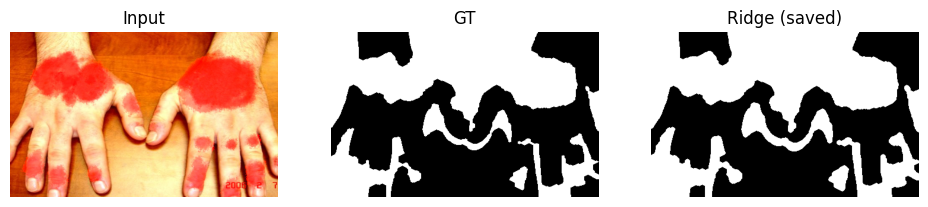

In [13]:
show(13)

In [9]:
# =========================
# Learning-curve visualizer
# =========================
def visualize_learning_curves(
    train_loss=None, val_loss=None,
    train_acc=None,  val_acc=None,
    non_ml_acc=None,
    start_epoch=1,
    suptitle=None
):
    """
    - ML mode: provide train_loss/val_loss and train_acc/val_acc (lists of equal length).
    - Non-ML mode: provide non_ml_acc (float in [0,1]) and leave the others as None.
    """
    is_ml = (
        train_acc is not None and val_acc is not None and
        train_loss is not None and val_loss is not None
    )

    if is_ml:
        epochs = list(range(start_epoch, start_epoch + len(train_loss)))
        fig, axes = plt.subplots(1, 2, figsize=(12, 3.2))

        # Log-loss
        ax = axes[0]
        ax.plot(epochs, train_loss, label="training")
        ax.plot(epochs, val_loss,   label="validation")
        ax.set_title("Log-loss (cost function)")
        ax.set_xlabel("epoch"); ax.set_ylim(bottom=min(min(train_loss), min(val_loss)) * 0.95)
        ax.legend()

        # Accuracy
        ax = axes[1]
        ax.plot(epochs, train_acc, label="training")
        ax.plot(epochs, val_acc,   label="validation")
        ax.set_title("Accuracy")
        ax.set_xlabel("epoch"); ax.set_ylim(0.0, 1.0)
        ax.legend()

        if suptitle:
            fig.suptitle(suptitle)
        plt.tight_layout()
        plt.show()
        return

    # Non-ML mode: plot a single accuracy point from ridge-based filled masks
    if non_ml_acc is None:
        raise ValueError("Non-ML mode requires non_ml_acc (float in [0,1]).")

    fig, ax = plt.subplots(1, 1, figsize=(6, 3.2))
    ax.plot([1], [non_ml_acc], marker="o", label="dataset")
    ax.set_xlim(0.8, 1.2)
    ax.set_ylim(0.0, 1.0)
    ax.set_xticks([1]); ax.set_xticklabels(["try #1"])
    ax.set_title("Accuracy")
    ax.set_ylabel("pixel accuracy")
    ax.legend()
    if suptitle:
        fig.suptitle(suptitle)
    plt.tight_layout()
    plt.show()


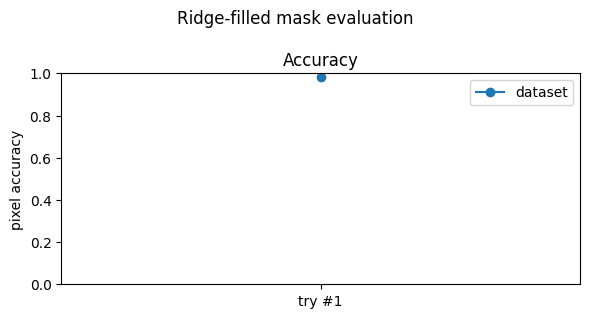

In [10]:
# ... after you compute `micro` from totals:
non_ml_pixel_acc = micro["pixel_acc"]  # accuracy from ridge-filled predictions vs GT
visualize_learning_curves(non_ml_acc=non_ml_pixel_acc, suptitle="Ridge-filled mask evaluation")


In [ ]:
show_all_images_ridge_and_gt(limit=None, show_filled_pred=True, save_dir=None)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

# Define paths as provided
image_dir = "/content/drive/MyDrive/dataset3/images3"
mask_dir  = "/content/drive/MyDrive/dataset3/masks2"           # GT masks (lesion=white)
ridge_dir = "/content/drive/MyDrive/dataset3/masks_ridge"      # Ridge masks (white lines)

# Function to apply dynamic thresholding (Otsu's method)
def apply_dynamic_threshold(pred_mask):
    """
    Applies a dynamic threshold (e.g., Otsu's method) for binarizing the mask.
    """
    if pred_mask.dtype != np.uint8:
        pred_mask = (pred_mask * 255).astype(np.uint8)

    _, binarized_mask = cv2.threshold(pred_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binarized_mask

# Function to compute metrics (IoU, Dice, F1 Score)
def compute_metrics(gt_mask, pred_mask):
    """
    Computes IoU, Dice score, and F1 score between ground truth mask and predicted mask.
    """
    gt_mask = (gt_mask > 0).astype(np.uint8)
    pred_mask = apply_dynamic_threshold(pred_mask)

    intersection = np.sum(gt_mask & pred_mask)
    union = np.sum(gt_mask) + np.sum(pred_mask) - intersection

    # Compute Dice coefficient
    dice = 2 * intersection / (np.sum(gt_mask) + np.sum(pred_mask) + 1e-6)

    # Compute F1 score
    precision = intersection / (np.sum(pred_mask) + 1e-6)
    recall = intersection / (np.sum(gt_mask) + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

    # Compute IoU
    iou = intersection / (union + 1e-6)

    return iou, dice, f1_score

# Function to compute average metrics across all images
def compute_avg_metrics(gt_masks, pred_masks):
    """
    Computes average IoU, Dice, and F1 scores across multiple images.
    """
    total_iou = 0
    total_dice = 0
    total_f1 = 0
    num_images = len(gt_masks)

    for i in range(num_images):
        gt_mask = gt_masks[i]
        pred_mask = pred_masks[i]

        iou, dice, f1_score = compute_metrics(gt_mask, pred_mask)

        total_iou += iou
        total_dice += dice
        total_f1 += f1_score

    avg_iou = total_iou / num_images
    avg_dice = total_dice / num_images
    avg_f1 = total_f1 / num_images

    return avg_iou, avg_dice, avg_f1

# Load all ground truth (GT) and predicted ridge masks
gt_masks = []
pred_masks = []

# Get the GT masks and ridge masks
gt_mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))
ridge_mask_paths = sorted(glob(os.path.join(ridge_dir, "*.png")))

# Ensure paths match up (e.g., Image1_mask.png for GT and Image1_ridge.png for predicted ridge mask)
for gt_path, ridge_path in zip(gt_mask_paths, ridge_mask_paths):
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(ridge_path, cv2.IMREAD_GRAYSCALE)

    gt_masks.append(gt_mask)
    pred_masks.append(pred_mask)

# Compute the average metrics for all images
avg_iou, avg_dice, avg_f1 = compute_avg_metrics(gt_masks, pred_masks)

# Print results as percentages
print(f"Average IoU: {avg_iou*100:.2f}%, Average Dice: {avg_dice*100:.2f}%, Average F1 Score: {avg_f1*100:.2f}%")


ZeroDivisionError: division by zero